In [86]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [87]:
%%time
ml = ncbi.pubmed('main', ['pubmed_id', 'year'])

CPU times: total: 1.7 s
Wall time: 1.64 s


In [88]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

ref_literature = datasets.reference_publications(taxon)

agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

gene2pubmed = gene2lit
gene2pubmed = pd.merge(gene2pubmed, ml, how='left')
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values

# no cutoff year
gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\u

In [89]:
df_array = []
for prefix in ['transcriptomics', 'aff_ms', 'crispr', 'gwas']:
    t = pd.read_csv('../data/' + prefix + '_pubmed_ids.csv')
    t['type_of_study'] = prefix
    df_array.append(t)
collected_pmids = pd.concat(df_array).reset_index(drop=True)
collected_pmids = pd.merge(collected_pmids, ml)
pmid_dict = collected_pmids.groupby('type_of_study')['pubmed_id'].apply(set).to_dict()

In [90]:
collected_pmids.to_csv('../data/all_collected_pmids.csv', index=False)

In [91]:
collected_pmids['year'].min()

2003

Main figure and 2003 figure

In [92]:
df_array = []

t = pd.read_csv('../data/gwas_hits_5e-08.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_hits_0.05.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

In [93]:
prot_genes = hits_df[(hits_df['set'] == 'genome') & (hits_df['type'] == 'crispr')]['gene_ncbi'].values

MannwhitneyuResult(statistic=62851.0, pvalue=1.2631971583100559e-06)
MannwhitneyuResult(statistic=35690.0, pvalue=2.1150829206607464e-06)
MannwhitneyuResult(statistic=586326.0, pvalue=3.263587508299758e-112)
MannwhitneyuResult(statistic=1976138.5, pvalue=1.0117841058364782e-265)
MannwhitneyuResult(statistic=1172081.0, pvalue=2.6308542613978625e-79)
MannwhitneyuResult(statistic=1287701.0, pvalue=6.172858452442905e-68)
MannwhitneyuResult(statistic=212755.0, pvalue=3.466146968828419e-17)
MannwhitneyuResult(statistic=157533.5, pvalue=6.483972362711481e-23)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


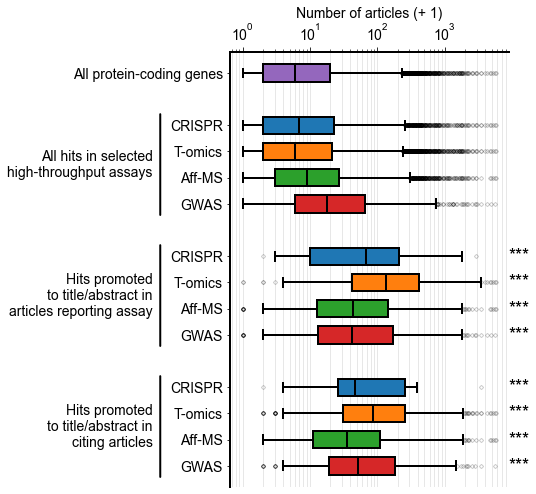

In [95]:
fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = hits_df_slice.groupby('set')['gene_ncbi'].apply(set).to_dict()
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    print(scipy.stats.mannwhitneyu(data[0], data[1]))
    print(scipy.stats.mannwhitneyu(data[0], data[2]))
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    for pos in positions[1:]:
        ax.text(s='***', x=max_val*1.5, y=pos, ha='left', va='center', fontsize=18)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.06

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits in selected\nhigh-throughput assays', 
        y=-1.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\narticles reporting assay', 
        y=-2.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

plt.savefig('../img/filter_figure.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/filter_figure.pdf', bbox_inches='tight')

export.image('general', p='figures/filter_figure.pdf', date=True)
export.raster_image('general', p='figures/filter_figure.png', date=True, dpi=600)

MannwhitneyuResult(statistic=83322.0, pvalue=0.0001807275995910169)
MannwhitneyuResult(statistic=55825.5, pvalue=0.0007214506044576915)
MannwhitneyuResult(statistic=1000241.0, pvalue=4.589607297439517e-84)
MannwhitneyuResult(statistic=3432079.0, pvalue=8.372817722128931e-164)
MannwhitneyuResult(statistic=1611395.5, pvalue=1.3599070344771256e-33)
MannwhitneyuResult(statistic=1730074.5, pvalue=3.531590091878298e-26)
MannwhitneyuResult(statistic=238882.0, pvalue=1.059429215983186e-08)
MannwhitneyuResult(statistic=192356.0, pvalue=1.233154257338839e-08)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


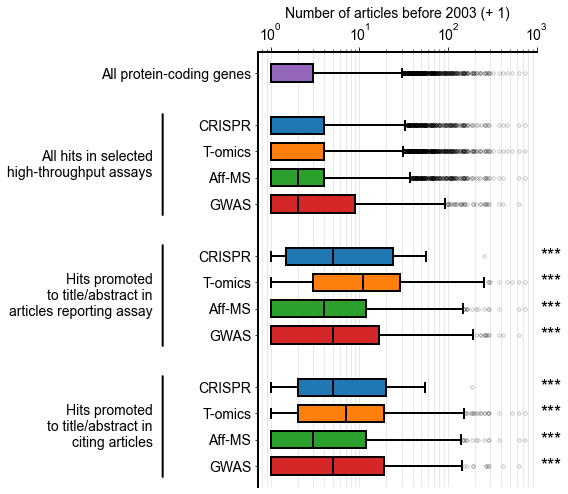

In [50]:
fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed[gene2pubmed['year'] <= 2002]
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = hits_df_slice.groupby('set')['gene_ncbi'].apply(set).to_dict()
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type)) & 
                    (gene2pubmed['year'] <= 2002)]
    .value_counts('gene_ncbi').to_dict()
    )
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    print(scipy.stats.mannwhitneyu(data[0], data[1]))
    print(scipy.stats.mannwhitneyu(data[0], data[2]))
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    for pos in positions[1:]:
        ax.text(s='***', x=max_val*1.5, y=pos, ha='left', va='center', fontsize=18)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles before 2003 (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.06

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits in selected\nhigh-throughput assays', 
        y=-1.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\narticles reporting assay', 
        y=-2.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

plt.savefig('../img/filter_figure_up_to_2003_.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/filter_figure_up_to_2003_.pdf', bbox_inches='tight')

export.image('general', p='figures/filter_figure_up_to_2003_.pdf', date=True)
export.raster_image('general', p='figures/filter_figure_up_to_2003_.png', date=True, dpi=600)

Alternative p value thresholds

MannwhitneyuResult(statistic=62851.0, pvalue=1.2631971583100559e-06)
MannwhitneyuResult(statistic=35690.0, pvalue=2.1150829206607464e-06)
MannwhitneyuResult(statistic=444941.0, pvalue=9.170252858106141e-87)
MannwhitneyuResult(statistic=887529.0, pvalue=3.009815216564629e-148)
MannwhitneyuResult(statistic=1172081.0, pvalue=2.6308542613978625e-79)
MannwhitneyuResult(statistic=1287701.0, pvalue=6.172858452442905e-68)
MannwhitneyuResult(statistic=63333.5, pvalue=6.75273046229931e-14)
MannwhitneyuResult(statistic=54147.0, pvalue=2.45937282584801e-16)


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


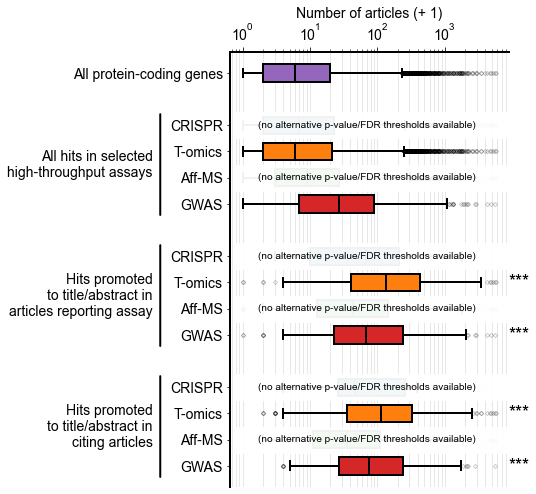

In [85]:
df_array = []

t = pd.read_csv('../data/gwas_hits_1e-10.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_hits_0.0001.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = hits_df_slice.groupby('set')['gene_ncbi'].apply(set).to_dict()
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    print(scipy.stats.mannwhitneyu(data[0], data[1]))
    print(scipy.stats.mannwhitneyu(data[0], data[2]))
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    if (hit_type != 'crispr') & (hit_type != 'aff_ms'):
        for pos in positions[1:]:
                ax.text(s='***', x=max_val*1.5, y=pos, ha='left', va='center', fontsize=18)
    else:
        for pos in positions:
                ax.text(s='(no alternative p-value/FDR thresholds available)', 
                        x=70, 
                        y=pos, ha='center', va='center', fontsize=10, zorder=200)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.06

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits in selected\nhigh-throughput assays', 
        y=-1.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\narticles reporting assay', 
        y=-2.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

ax.set_xlim(ax.get_xlim())
ax.fill_between(y1=[-0.7,-0.7], y2=[-0.9,-0.9], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-1.7,-1.7], y2=[-1.9,-1.9], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-2.7,-2.7], y2=[-2.9,-2.9], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)

ax.fill_between(y1=[-1.1,-1.1], y2=[-1.3,-1.3], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-2.1,-2.1], y2=[-2.3,-2.3], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)
ax.fill_between(y1=[-3.1,-3.1], y2=[-3.3,-3.3], x=np.array(ax.get_xlim())+0.1, color='w', zorder=100, alpha=0.95)

plt.savefig('../img/filter_figure_alt_p.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/filter_figure_alt_p.pdf', bbox_inches='tight')

export.image('general', p='figures/filter_figure_alt_p.pdf', date=True)
export.raster_image('general', p='figures/filter_figure_alt_p.png', date=True, dpi=600)

In [74]:
yticks

array([-0.4, -0.8, -1. , -1.2, -1.4, -1.8, -2. , -2.2, -2.4, -2.8, -3. ,
       -3.2, -3.4])